<a href="https://colab.research.google.com/github/osmarbraz/sri/blob/main/4_AnaliseDados_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise do conjunto de dados

Realiza a análise do conjunto de dados utilizando os arquivos:
- `dataset.zip`
- `datasetpos.zip`



# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório do notebook no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioNotebook():
    """
      Verifica se existe o diretório do notebook no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_NOTEBOOK):  
        # Cria o diretório
        os.makedirs(DIRETORIO_NOTEBOOK)
        logging.info("Diretório do notebook criado: {}".format(DIRETORIO_NOTEBOOK))
    
    return DIRETORIO_NOTEBOOK

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModelosParametros:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )    

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [ ]:
# Instala dependências do spacy
!pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.


In [ ]:
# Instala uma versão específica
!pip install -U spacy==3.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.8 Instalação do BERT

Instala a interface pytorch para o BERT by Hugging Face. 

https://huggingface.co/docs/transformers/installation



In [ ]:
!pip install -U transformers==4.26.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 22.5 MB/s eta 0:00:00


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModelosParametros(     
    max_seq_len = 512,
    
    #pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
        
    do_lower_case = False,   # default True  
    output_attentions = False,  # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do notebook
DIRETORIO_NOTEBOOK = "SRI"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos de dados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_NOTEBOOK + "/"

# Diretório no google drive com os arquivos de dados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/" + DIRETORIO_NOTEBOOK + "/data/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 14
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do documento default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 spaCy

## 3.1 Download arquivo modelo

Uso:
https://spacy.io/usage

Modelos:
https://spacy.io/models

In [ ]:
!python -m spacy download $model_args.modelo_spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-02 20:09:25.454750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 20:09:25.454884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 20:09:25.454909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

## 3.2 Carrega o modelo

In [ ]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

nlp = spacy.load(model_args.modelo_spacy)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 3.3 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [ ]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).
    
      Parâmetros:
        `nlp` - Um modelo spaCy carregado.           
    """
    
    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords 

Lista dos stopwords

In [ ]:
print("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

Quantidade de stopwords: 416.
{'quarto', 'daquele', 'irá', 'nas', 'mal', 'vós', 'ter', 'catorze', 'dez', 'custa', 'podia', 'estará', 'cento', 'primeira', 'duas', 'debaixo', 'vezes', 'adeus', 'certamente', 'algo', 'umas', 'novos', 'parte', 'deve', 'diz', 'fora', 'bom', 'vem', 'coisa', 'vai', 'tenho', 'quando', 'talvez', 'outros', 'até', 'tempo', 'eventual', 'baixo', 'mas', 'quero', 'ponto', 'obrigado', 'demais', 'tentaram', 'tais', 'outra', 'acerca', 'muitos', 'conselho', 'dizer', 'estás', 'zero', 'diante', 'nova', 'tudo', 'conhecido', 'todos', 'está', 'põem', 'dezoito', 'tu', 'disso', 'por', 'vossos', 'longe', 'posição', 'tanta', 'sete', 'aqui', 'para', 'corrente', 'meio', 'dão', 'nunca', 'primeiro', 'quanto', 'quem', 'iniciar', 'boa', 'grande', 'grandes', 'lhe', 'dezasseis', 'dá', 'sois', 'tentei', 'bastante', 'cujo', 'estou', 'nossa', 'fazemos', 'conhecida', 'onde', 'ela', 'lado', 'geral', 'somente', 'máximo', 'outras', 'porquanto', 'mais', 'quinta', 'relação', 'último', 'esse', 'nem

### getVerbos
Localiza os verbos da sentença

In [ ]:
# Import das bibliotecas.
import spacy   
from spacy.util import filter_spans
from spacy.matcher import Matcher

# (verbo normal como auxilar ou auxilar) + vários verbos auxiliares +verbo principal ou verbo auxiliar
gramaticav1 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                                  
                {"POS": "VERB", "OP": "?", "DEP": {"IN": ["ROOT","aux","xcomp","aux:pass"]}},  #verbo normal como auxiliar
                {"POS": "AUX", "OP": "*", "DEP": {"IN": ["aux","xcomp","aux:pass"]}},  #verbo auxiliar   
                {"POS": "VERB", "OP": "+"}, #verbo principal
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop","aux","xcomp","aux:pass"]}},  #verbo auxiliar
               ] 

# verbo auxiliar + verbo normal como auxiliar + conjunção com preposição + verbo
gramaticav2 =  [               
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                   
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["ROOT"]}},  #verbo principal       
                {"POS": "SCONJ", "OP": "+", "DEP": {"IN": ["mark"]}}, #conjunção com preposição
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["xcomp"]}}, #verbo normal como complementar
               ] 

#Somente verbos auxiliares
gramaticav3 =  [
                {"POS": "AUX", "OP": "?"},  #Verbos auxiliar 
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop"]}},  #Verbos auxiliar de ligação (AUX+(cop))
                {"POS": "ADJ", "OP": "+", "DEP": {"IN": ["ROOT"]}}, 
                {"POS": "AUX", "OP": "?"}  #Verbos auxiliar 
               ] 

matcherv = Matcher(nlp.vocab)
         
matcherv.add("frase verbal", [gramaticav1])
matcherv.add("frase verbal", [gramaticav2])
matcherv.add("frase verbal", [gramaticav3])

#Retorna a Frase Verbal
def getVerbos(periodo):    
  #Processa o período
  doc1 = nlp(periodo.text)
  
  # Chama o mather para encontrar o padrão
  matches = matcherv(doc1)

  padrao = [doc1[start:end] for _, start, end in matches]

  #elimina as repetições e sobreposições
  #return filter_spans(padrao)
  lista1 = filter_spans(padrao)

  # Converte os itens em string
  lista2 = []
  for x in lista1:
      lista2.append(str(x))
  
  return lista2

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [ ]:
def getDicPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = dict()
  
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

In [ ]:
def getDicTodasPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades    
  novo_dic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}
    
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [ ]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getSomaDic

Soma os valores de dicionários com as mesmas chaves.

In [ ]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):
    
  # Soma os dicionários da lista
  novo_dic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))
 
  return novo_dic

### getTokensSentenca

Retorna a lista de tokens da sentenca.

In [ ]:
def getTokensSentenca(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.text)

  return lista

### getPOSTokensSentenca

Retorna a lista das POS-Tagging dos tokens da sentenca.

In [ ]:
def getPOSTokensSentenca(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.pos_)

  return lista


### getListaTokensPOSSentenca

Retorna duas listas uma com os tokens e a outra com a POS-Tagging dos tokens da sentenca.

In [ ]:
def getListaTokensPOSSentenca(sentenca):
  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista_tokens = []
  lista_postagging = []

  # Percorre a sentença adicionando os tokens e as POS
  for token in doc:    
    lista_tokens.append(token.text)
    lista_postagging.append(token.pos_)
    
  return lista_tokens, lista_postagging

### Tradução das tags

Tags de palavras universal

https://universaldependencies.org/u/pos/

Detalhes das tags em português:
http://www.dbd.puc-rio.br/pergamum/tesesabertas/1412298_2016_completo.pdf

In [ ]:
#dicionário que contêm pos tag universal e suas explicações
palavra_universal_dict = {
  "X"    : "Outro",
  "VERB" : "Verbo ",
  "SYM"  : "Símbolo",
  "CONJ" : "Conjunção",
  "SCONJ": "Conjunção subordinativa",
  "PUNCT": "Pontuação",
  "PROPN": "Nome próprio",
  "PRON" : "Pronome substativo",
  "PART" : "Partícula, morfemas livres",
  "NUM"  : "Numeral",
  "NOUN" : "Substantivo",
  "INTJ" : "Interjeição",
  "DET"  : "Determinante, Artigo e pronomes adjetivos",
  "CCONJ": "Conjunção coordenativa",
  "AUX"  : "Verbo auxiliar",
  "ADV"  : "Advérbio",
  "ADP"  : "Preposição",
  "ADJ"  : "Adjetivo"
}
  
#Explica a POS
def getPOSPalavraUniversalTraduzido(palavra):
  if palavra in palavra_universal_dict.keys():
      traduzido = palavra_universal_dict[palavra]
  else:
      traduzido = "NA" 
  return traduzido

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [ ]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getSentencaSalientePOS

Retorna uma lista das palavras do tipo especificado.

In [ ]:
def getSentencaSalientePOS(sentenca, pos, tipoSaliente="NOUN"):
  
  # Lista dos tokens
  lista = []

  # Percorre a sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é do tipo especeficado
    if pos[i] == tipoSaliente:
      lista.append(token)

  # Retorna o documento
  return lista

# 4 BERT

## 4.1 Modelo Pré-treinado BERT

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [ ]:
# Import das bibliotecas
from transformers import BertModel

# Carrega o modelo
model = BertModel.from_pretrained(model_args.pretrained_model_name_or_path,
                                  output_attentions=model_args.output_attentions,
                                  output_hidden_states=model_args.output_hidden_states)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 4.2 Tokenizador BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

In [ ]:
# Import das bibliotecas
from transformers import BertTokenizer

# Carrega o tokenizador
#tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path)

tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path, 
                                          do_lower_case=model_args.do_lower_case)

## 4.3 Funções Auxiliares

### getNomeModeloBERT

In [ ]:
def getNomeModeloBERT(model_args):
    '''    
    Recupera uma string com uma descrição do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `MODELO_BERT` - Nome do modelo BERT.
    '''

    # Verifica o nome do modelo(default SEM_MODELO_BERT)
    MODELO_BERT = "SEM_MODELO_BERT"
    
    if 'neuralmind' in model_args.pretrained_model_name_or_path:
        MODELO_BERT = "_BERTimbau"
        
    else:
        if 'multilingual' in model_args.pretrained_model_name_or_path:
            MODELO_BERT = "_BERTmultilingual"
            
    return MODELO_BERT

### getTamanhoBERT

In [ ]:
def getTamanhoBERT(model_args):
    '''    
    Recupera uma string com o tamanho(dimensão) do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `TAMANHO_BERT` - Nome do tamanho do modelo BERT.
    '''
    
    # Verifica o tamanho do modelo(default large)
    TAMANHO_BERT = "_large"
    
    if 'base' in model_args.pretrained_model_name_or_path:
        TAMANHO_BERT = "_base"
        
    return TAMANHO_BERT  

### getPalavrasDesconhecidasBERT

In [ ]:
def getPalavrasDesconhecidasBERT(sentenca_token):
  '''    
    Conta o número de palavras desconhecidas na sentença tokenizada pelo BERT.
    
    Parâmetros:
    `sentenca_token` - Lista de tokens da sentença gerado pelo BERT.
    
    Retorno:
    `lista_palavras_desconhecidas` - Lista com as palavras desconhecidas.
  '''
  proximo = False
  achei = False
  token_palavra = ""
  token_bert = []
  lista_palavras_desconhecidas = []      

  for k, token in enumerate(sentenca_token):          
      # Sem ##     
      if "##" not in token:
        token_palavra = token
        token_bert = []
        token_bert.append(token)

      # Verifica se é um token desconhecido
      if "##" in token:       
        achei = True
        # Guarda o token
        token_palavra = token_palavra + token[2:]        
        token_bert.append(token)
        # Se o próximo é continuação do token
        if k+1 < len(sentenca_token):
          if "##" in sentenca_token[k+1]:          
            proximo = True
          else:
            proximo = False
        else:
            proximo = False      

      # Se terminei o token guarda a palavra
      if achei == True and proximo == False:
          achei = False          
          lista_palavras_desconhecidas.append([token_palavra, token_bert])
          token_palavra = ""
          token_bert = []

  return lista_palavras_desconhecidas

### Recupera detalhes do BERT

In [ ]:
# Verifica o nome do modelo BERT a ser utilizado
MODELO_BERT = getNomeModeloBERT(model_args)

# Verifica o tamanho do modelo(default large)
TAMANHO_BERT = getTamanhoBERT(model_args)

# 5 Estatísticas Dataset

## 5.1 Carregamento do Dataset

### 5.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_DATASET = "dataset.csv"
NOME_ARQUIVO_DATASET_COMPACTADO = "dataset.zip"
NOME_ARQUIVO_DATASET_POS = "datasetpos.csv"
NOME_ARQUIVO_DATASET_POS_COMPACTADO = "datasetpos.zip"

### 5.1.2 Cria o diretório local para receber os dados

In [ ]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/SRI


### 5.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia.")

INFO:root:Terminei a cópia.


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação.")

INFO:root:Terminei a descompactação.


### 5.1.4 Carregamento das lista com os dados dos arquivos e postagging

#### Carrega o arquivo dos dados e POS

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Abre o arquivo e retorna o DataFrame
df_dataset = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET, sep=";", encoding="UTF-8")
df_dataset_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO DOCUMENTOS: {}.".format(len(df_dataset)))
logging.info("TERMINADO DOCUMENTOS POS: {}.".format(len(df_dataset_pos)))

INFO:root:TERMINADO DOCUMENTOS: 20.
INFO:root:TERMINADO DOCUMENTOS POS: 20.


In [ ]:
df_dataset.sample(5)

,id,sentencas,documento
4,5,"['A seleção brasileira masculina de vôlei, que...","A seleção brasileira masculina de vôlei, que é..."
18,19,"['A ginasta Jade Barbosa, que obteve três meda...","A ginasta Jade Barbosa, que obteve três medalh..."
2,3,"['O ministro da Defesa, Nelson Jobim, informou...","O ministro da Defesa, Nelson Jobim, informou n..."
1,2,['Ao menos 17 pessoas morreram após a queda de...,Ao menos 17 pessoas morreram após a queda de u...
6,7,['A aviação israelense atacou 150 alvos na mad...,A aviação israelense atacou 150 alvos na madru...


In [ ]:
df_dataset_pos.sample(5)

,id,pos_documento
2,3,"[[['O', 'ministro', 'da', 'Defesa', ',', 'Nels..."
8,9,"[[['Um', 'total', 'de', '549', 'pessoas', 'mor..."
3,4,"[[['Usando', 'telescópios', 'do', 'Observatóri..."
19,20,"[[['Dois', 'terremotos', 'atingiram', 'a', 're..."
11,12,"[[['Um', 'atirador', 'matou', 'ao', 'menos', '..."


#### Corrigir os tipos de colunas dos dados e POS

Em dados:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
df_dataset["sentencas"] = df_dataset["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

df_dataset_pos["pos_documento"] = df_dataset_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO DOCUMENTOS: {}.".format(len(df_dataset)))
logging.info("TERMINADO CORREÇÃO DOCUMENTOS POS: {}.".format(len(df_dataset_pos)))

INFO:root:TERMINADO CORREÇÃO DOCUMENTOS: 20.
INFO:root:TERMINADO CORREÇÃO DOCUMENTOS POS: 20.


#### Criando dados indexados 

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_indexado = df_dataset.set_index(["id"])
df_dataset_indexado.head()

,sentencas,documento
id,,
1,"[Depois de 20 dias de tempo seco, voltou a cho...","Depois de 20 dias de tempo seco, voltou a chov..."
2,[Ao menos 17 pessoas morreram após a queda de ...,Ao menos 17 pessoas morreram após a queda de u...
3,"[O ministro da Defesa, Nelson Jobim, informou ...","O ministro da Defesa, Nelson Jobim, informou n..."
4,[Usando telescópios do Observatório Europeu Su...,Usando telescópios do Observatório Europeu Sul...
5,"[A seleção brasileira masculina de vôlei, que ...","A seleção brasileira masculina de vôlei, que é..."


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_pos_indexado = df_dataset_pos.set_index(["id"])
df_dataset_pos_indexado.head()

,pos_documento
id,
1,"[[[Depois, de, 20, dias, de, tempo, seco, ,, v..."
2,"[[[Ao, menos, 17, pessoas, morreram, após, a, ..."
3,"[[[O, ministro, da, Defesa, ,, Nelson, Jobim, ..."
4,"[[[Usando, telescópios, do, Observatório, Euro..."
5,"[[[A, seleção, brasileira, masculina, de, vôle..."


## 5.2 Estatísticas

### 5.2.1 Processamento estatísticas



In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_sentencas = []
stats_sentencas_pos = []
stats_pos_palavras_sentenca_documento =[]

print("Processando",len(df_dataset),"documentos")

total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
qtde_abaixo_512 = 0
total_2_ou_mais_locucoes_verbais = 0
sentencas_com_uma_palavra = 0

total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

dicionario_palavras = {}
lista_palavras_desconhecidas_geral = []
documento_tokenizado = []

# Barra de progresso dos documentos
df_dataset_bar = tqdm_notebook(df_dataset.iterrows(), desc=f"Documentos", unit=f" documento", total=len(df_dataset))

# Percorre os documentos
for i, linha_documento in df_dataset_bar:  

    id_documento = linha_documento["id"]
    #print("id_documento:",id_documento)
 
    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentencas"]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Localiza e carrega a lista das POSTagging das sentenças do documento de acordo com o tipo armazenado
    # Descarta a posição 0 com o id do documento e considera somente a posição 1 com as sentenças
    lista_pos_documento = df_dataset_pos.iloc[i][1]    
    #print("lista_pos_documento:",lista_pos_documento)
    #print("len(lista_pos_documento):",len(lista_pos_documento))  
    
    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(lista_sentenca_documento)

    total_palavras_documento = 0    
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0

    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []
    
    # Acumula os dicionários de POS das sentenças
    lista_pos_doc = []

    # Acumula a lista de  POS das sentenças
    stats_pos_palavras_sentenca = []

    # Guarda as sentenças tokenizadas pelo BERT do documento
    documento_tokenizado_sentenca = []
  
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      #print("sentenca:",sentenca)
      sentenca_token = lista_pos_documento[j][0]
      #print("sentenca_token:",sentenca_token)
      #print("len(sentenca_token):",len(sentenca_token))
      sentenca_pos = lista_pos_documento[j][1]
      #print("sentenca_pos:",sentenca_pos)
      sentenca_verbos = lista_pos_documento[j][2]
      #print("sentenca_verbos:",sentenca_verbos)
    
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        sentencas_com_uma_palavra = sentencas_com_uma_palavra + 1
       
      # Retorna uma lista com os verbos da sentença      
      qtde_locucoes_verbais_sentenca = len(sentenca_verbos)
      total_locucoes_verbais_documento = total_locucoes_verbais_documento + qtde_locucoes_verbais_sentenca

      if qtde_locucoes_verbais_sentenca >= 2:
          total_2_ou_mais_locucoes_verbais = total_2_ou_mais_locucoes_verbais + 1
      
      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))
      
      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)
            
      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada = tokenizer.tokenize(sentenca)

      # Guarda a sentença tokenizada do documento
      documento_tokenizado_sentenca = documento_tokenizado_sentenca + sentenca_tokenizada

      # Quantidade de tokens por Sentença
      qtde_token_BERT = len(sentenca_tokenizada)     
      
      lista_palavras_desconhecidas_sentenca = getPalavrasDesconhecidasBERT(sentenca_tokenizada)
      
      # Acumula a quantidade de tokens da Sentença
      total_tokens_BERT_documento = total_tokens_BERT_documento + qtde_token_BERT

      # Gera as postagging das palavras da sentença
      pos_palavras_sentenca = []

      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging   
        pos_palavras_sentenca.append([linha_documento[0], j, palavra, sentenca_pos[k]])
        
        # Estatísticas das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1
        
        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:                    
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da quantidade de palavras da Sentença
      stats_sentencas.append(
         {  
            "id": id_documento,  
            "sentenca": j,  
            "qtdepalavras" : qtdePalavra,                        
            "qtdetokensbert" : qtde_token_BERT,
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdelocverbo" : qtde_locucoes_verbais_sentenca ,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
            "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_sentenca),
         }
      )
      
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca

      lista_palavras_desconhecidas_documento = lista_palavras_desconhecidas_documento + lista_palavras_desconhecidas_sentenca
      
      # Guarda as pos da sentença 
      stats_pos_palavras_sentenca = stats_pos_palavras_sentenca + pos_palavras_sentenca

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_pos_doc.append(contaPosSentenca)

    # Guarda as sentenças do documento tokenizada
    documento_tokenizado.append(documento_tokenizado_sentenca)

    # Acumula a postagging das sentenças do documento
    stats_pos_palavras_sentenca_documento = stats_pos_palavras_sentenca_documento + stats_pos_palavras_sentenca  

    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    # Guarda o total de tokens do conjunto de dados
    total_tokens_geral = total_tokens_geral + total_tokens_BERT_documento

    # Guarda a lista de palavras desconhecidas
    lista_palavras_desconhecidas_geral = lista_palavras_desconhecidas_geral + lista_palavras_desconhecidas_documento

    if total_tokens_BERT_documento < 512 :
        qtde_abaixo_512 = qtde_abaixo_512 + 1

    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:  
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística da divisão
    stats_documentos.append(
      {  
        "id": id_documento, 
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,                
        "qtdetokensbert" : total_tokens_BERT_documento,
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverbosauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos    
    stats_documentos_pos.append([linha_documento[0], lista_pos_doc])    

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", sentencas_com_uma_palavra)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de tokens BERT                           :", total_tokens_geral)
print("Total de documentos abaixo 512                 :", qtde_abaixo_512)  
print("Total de palavras desconhecidas repetidas      :", len(lista_palavras_desconhecidas_geral))  
print("Total de palavras desconhecidas sem repetições :", len(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral])))) 
print("Total de sentenças com 2 ou mais loc verbos    :", total_2_ou_mais_locucoes_verbais, "sendo {:.2%} do total de sentenças".format(total_2_ou_mais_locucoes_verbais/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 20 documentos


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

Total de Sentenças                             : 101
Total de Sentenças com uma palavra             : 1
Total de palavras                              : 2706
Total de palavras distintas                    : 1113
Total de palavras sem stopwords                : 1609
Total de tokens BERT                           : 3232
Total de documentos abaixo 512                 : 20
Total de palavras desconhecidas repetidas      : 305
Total de palavras desconhecidas sem repetições : 263
Total de sentenças com 2 ou mais loc verbos    : 65 sendo 64.36% do total de sentenças
Total de sentenças com Verbos(VERB)            : 20 sendo 19.80% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 20 sendo 19.80% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 20 sendo 19.80% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 20 sendo 19.80% do total de sentenças


Converte a lista das pos tagging das palavras em um dataframe

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_palavras_pos = pd.DataFrame(stats_pos_palavras_sentenca_documento, columns=("id", "sentenca", "palavra", "pos")) 

In [ ]:
dfstats_palavras_pos.sample(5)

,id,sentenca,palavra,pos
1334,11,0,outras,DET
1187,9,2,urgente,ADJ
2181,16,7,do,ADP
906,8,0,interior,NOUN
433,4,2,Austral,PROPN


### 5.2.2 Conjunto de dados



In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_palavras_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB
count,152,534,61,58,64,217,1,572,124,47,279,347,32,3,215
unique,125,51,30,21,5,30,1,406,75,16,198,7,12,1,165
top,primeiro,de,não,foram,e,a,Serasa,pessoas,dois,que,Paulo,",",que,R$,informou
freq,4,139,7,10,55,44,1,11,5,24,9,193,12,3,6


### 5.2.3 Por documento

#### 5.2.3.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_documentos)

df_stats.describe(include="all")

,id,qtdesentencas,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverbosauxsubstantivo,qtdepalavrasdesconhecidas
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,10.50,5.05,135.30,161.60,80.45,10.60,10.75,13.65,28.60,42.25,15.25
std,5.92,2.50,48.61,54.32,28.28,4.96,4.63,5.92,12.41,17.13,6.92
min,1.00,2.00,51.00,62.00,31.00,3.00,3.00,5.00,10.00,15.00,4.00
25%,5.75,3.75,104.00,127.75,63.75,7.00,7.00,10.00,17.75,30.75,10.00
50%,10.50,4.00,140.50,172.50,85.00,10.00,10.50,12.00,27.00,39.00,16.00
75%,15.25,5.25,160.25,192.25,98.75,12.25,12.00,15.00,36.50,51.50,19.00
max,20.00,10.00,236.00,258.00,135.00,25.00,24.00,28.00,57.00,80.00,30.00


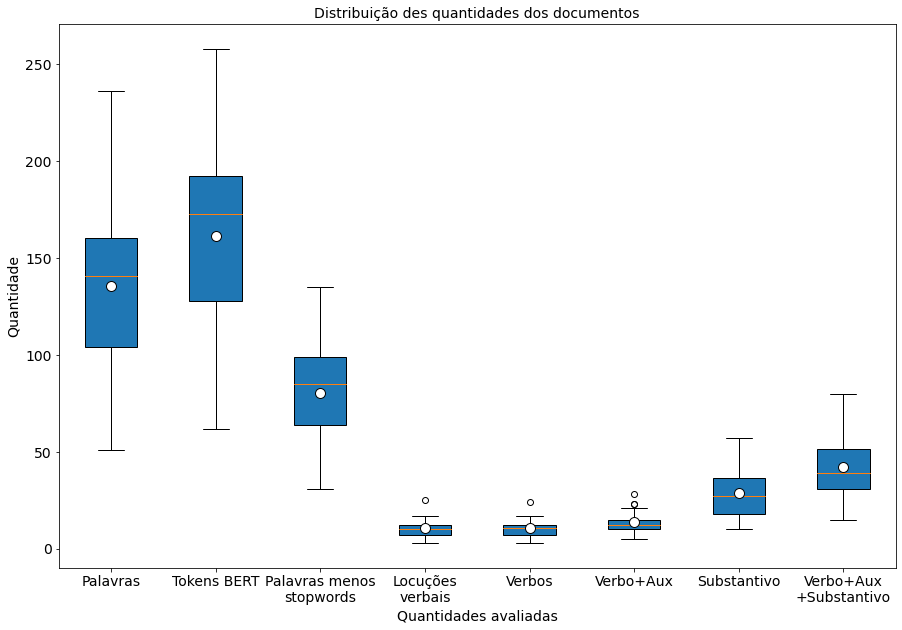

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos], 
           [x["qtdetokensbert"] for x in stats_documentos],
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras", 
           "Tokens BERT", 
           "Palavras menos\nstopwords", 
           "Locuções\nverbais", 
           "Verbos",
           "Verbo+Aux", 
           "Substantivo", 
           "Verbo+Aux\n+Substantivo"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.2.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_documentos_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_pos])

# Exibe as estatísticas
df_stats_documentos_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.0,20.00
mean,2.35,10.75,17.35,10.85,28.60,2.90,3.20,26.70,13.95,7.60,3.05,6.20,1.60,0.15,0.0,0.05
std,1.93,4.63,7.60,5.63,12.41,2.15,2.12,9.56,6.62,4.41,1.85,3.97,1.43,0.49,0.0,0.22
min,0.00,3.00,6.00,3.00,10.00,0.00,0.00,9.00,2.00,2.00,1.00,2.00,0.00,0.00,0.0,0.00
25%,1.00,7.00,12.00,7.75,17.75,1.75,2.00,19.00,8.75,4.00,2.00,3.00,0.75,0.00,0.0,0.00
50%,2.00,10.50,16.50,10.00,27.00,2.50,3.00,27.00,15.50,6.50,2.50,5.00,1.00,0.00,0.0,0.00
75%,3.25,12.00,21.50,13.00,36.50,4.00,4.00,32.75,18.25,11.00,4.25,7.25,2.00,0.00,0.0,0.00
max,7.00,24.00,33.00,26.00,57.00,8.00,8.00,46.00,26.00,17.00,7.00,17.00,4.00,2.00,0.0,1.00


Organiza os dados para gerar o boxplot

In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_documentos_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

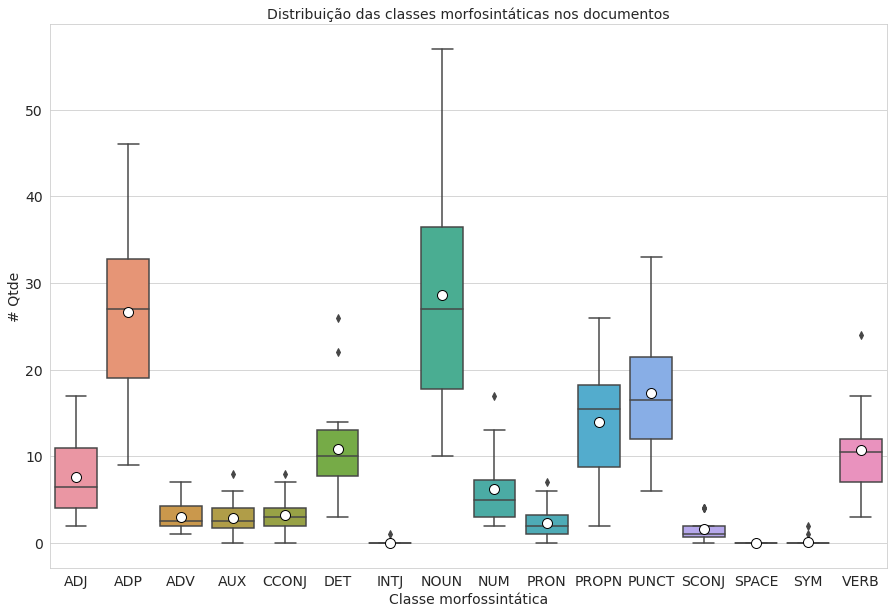

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_documentos_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_documentos_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

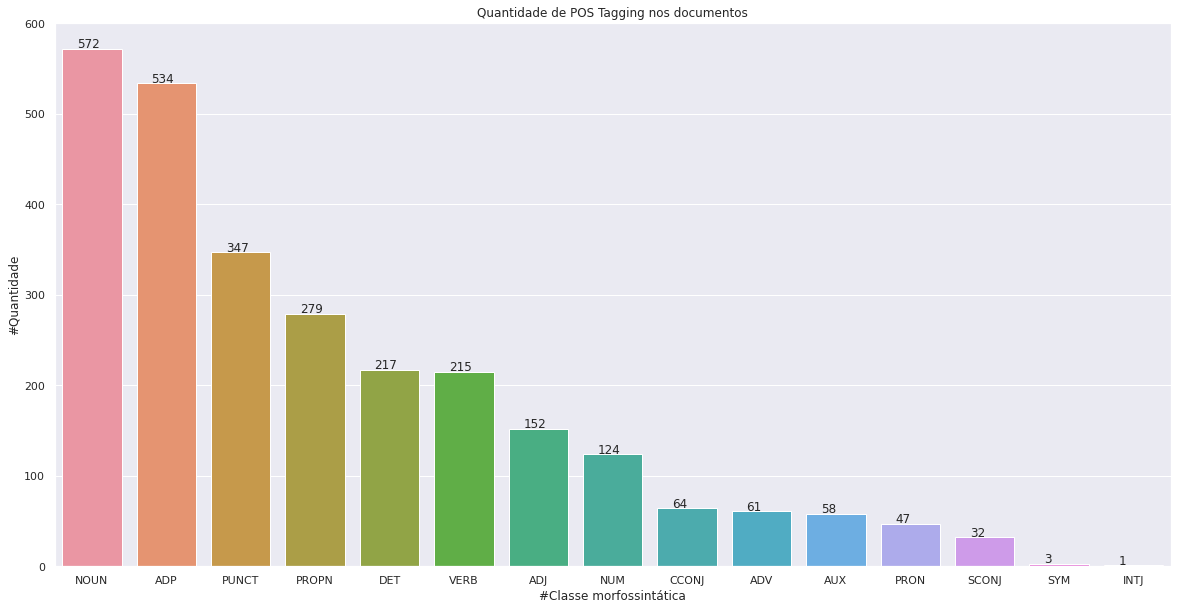

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_palavras_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_palavras_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.3 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [ ]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])  

, => 193
de => 143
. => 97
a => 61
da => 59
e => 55
do => 54
o => 47
na => 37
que => 36
em => 32
no => 31
um => 23
A => 20
com => 18
( => 18
) => 18
O => 18
' => 18
para => 17


#### 5.2.3.4 Lista palavras desconhecidas e ocorrências

Lista as 20 palavras desconhecidas pelo BERT com maiores ocorrência.

In [ ]:
lista_palavras_desconhecidas_ocorrencias = []

for palavra in sorted(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral]))):
  conta = 0  
  tokenizada = ""
  for x in sorted(lista_palavras_desconhecidas_geral, key = lambda x: x[0]):
    if x[0] == palavra:
      conta = conta + 1
      tokenizada = x[1]
  #print(palavra, "=>", tokenizada, "=>", conta)
  lista_palavras_desconhecidas_ocorrencias.append([palavra, tokenizada, conta])
  
for i, palavra in enumerate(sorted(lista_palavras_desconhecidas_ocorrencias, key = lambda x: x[2], reverse=True)):
  if i < 20:
     print(palavra[0], "=>", palavra[1], "=>", palavra[2])

terça => ['ter', '##ça'] => 4
Infraero => ['Inf', '##ra', '##ero'] => 3
Kaká => ['Ka', '##k', '##á'] => 3
giram => ['gira', '##m'] => 3
Bernardinho => ['Bernard', '##inho'] => 2
Bukavu => ['Bu', '##ka', '##v', '##u'] => 2
Congonhas => ['Congo', '##nha', '##s'] => 2
Coréia => ['Cor', '##éia'] => 2
Cumbica => ['Cu', '##mb', '##ica'] => 2
Dominó => ['Domin', '##ó'] => 2
Itaú => ['Ita', '##ú'] => 2
Jobim => ['Jo', '##bi', '##m'] => 2
Lanka => ['Lan', '##ka'] => 2
Maradona => ['Mara', '##don', '##a'] => 2
Marginal => ['Mar', '##gina', '##l'] => 2
Niigata => ['Ni', '##iga', '##ta'] => 2
PCC => ['PC', '##C'] => 2
PF => ['P', '##F'] => 2
Pyongyang => ['Py', '##ong', '##yan', '##g'] => 2
Robinho => ['Robin', '##ho'] => 2


### 5.2.4 Por sentença

#### 5.2.4.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,id,sentenca,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo,qtdepalavrasdesconhecidas
count,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00
mean,11.02,2.61,26.79,32.00,15.93,2.10,2.13,2.70,5.66,8.37,3.02
std,5.61,2.37,11.83,15.05,7.79,1.16,1.27,1.41,2.98,3.80,2.50
min,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.00,1.00,18.00,20.00,10.00,1.00,1.00,2.00,4.00,6.00,1.00
50%,11.00,2.00,25.00,31.00,15.00,2.00,2.00,2.00,6.00,8.00,3.00
75%,16.00,4.00,35.00,42.00,22.00,3.00,3.00,4.00,7.00,10.00,4.00
max,20.00,9.00,72.00,95.00,41.00,6.00,7.00,8.00,23.00,28.00,16.00


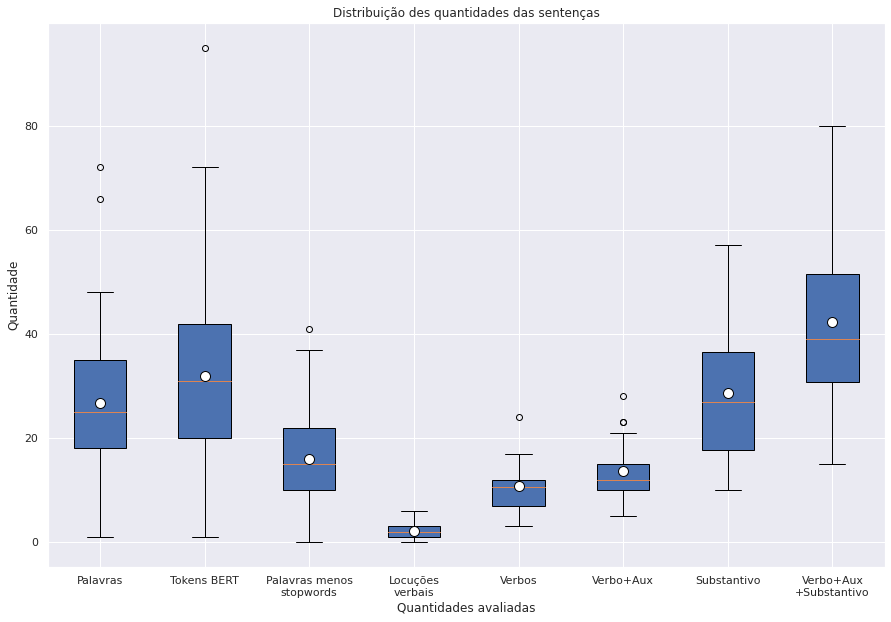

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_sentencas], 
           [x["qtdetokensbert"] for x in stats_sentencas],
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],
           [x["qtdelocverbo"] for x in stats_sentencas],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras", 
                     "Tokens BERT", 
                     "Palavras menos\nstopwords", 
                     "Locuções\nverbais", 
                     "Verbos",
                     "Verbo+Aux", 
                     "Substantivo", 
                     "Verbo+Aux\n+Substantivo"])

# Mostra o gráfico
plt.show()

#### 5.2.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_pos])

# Exibe as estatísticas
df_stats_sentencas_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ
count,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.00,101.0,1.01e+02
mean,0.47,2.13,3.44,2.15,5.66,0.57,0.63,5.29,2.76,1.50,0.60,1.23,0.32,0.03,0.0,9.90e-03
std,0.72,1.27,2.33,1.67,2.98,0.64,0.69,2.86,3.06,1.46,0.78,1.32,0.56,0.17,0.0,9.95e-02
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00e+00
25%,0.00,1.00,2.00,1.00,4.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00e+00
50%,0.00,2.00,3.00,2.00,6.00,0.00,1.00,5.00,1.00,1.00,0.00,1.00,0.00,0.00,0.0,0.00e+00
75%,1.00,3.00,4.00,3.00,7.00,1.00,1.00,7.00,4.00,2.00,1.00,2.00,1.00,0.00,0.0,0.00e+00
max,3.00,7.00,11.00,11.00,23.00,2.00,3.00,20.00,12.00,7.00,3.00,6.00,2.00,1.00,0.0,1.00e+00


In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

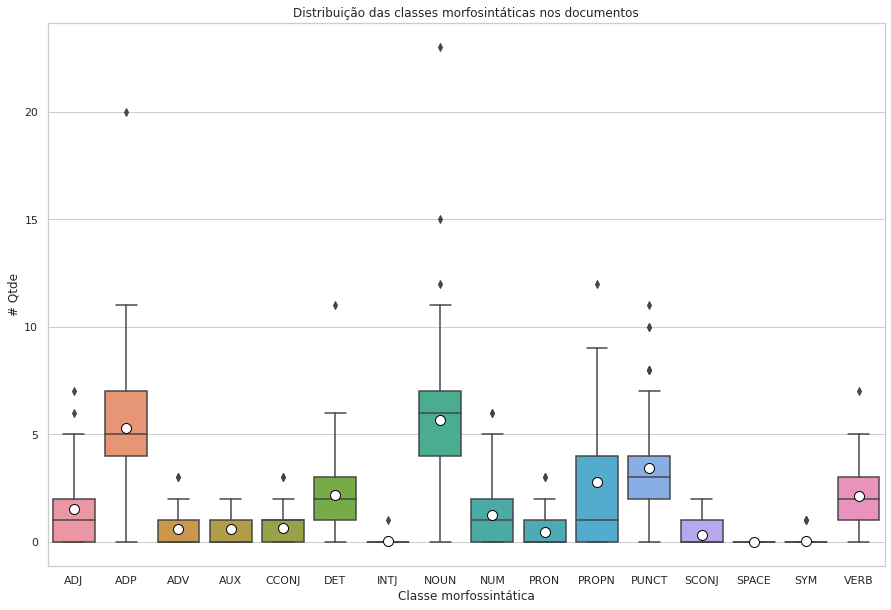

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

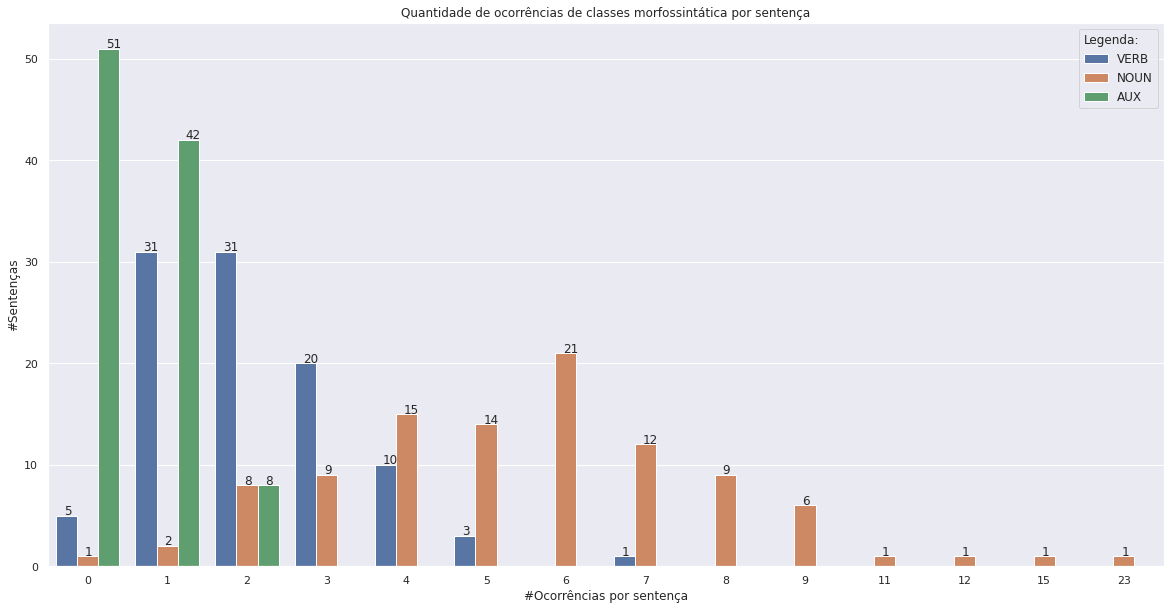

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_pos[df_stats_sentencas_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 20(#Sentenças) sentenças onde palavras da classe morfossintática verbo(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.3 Gráficos POS Tagging de sentenças do documento 

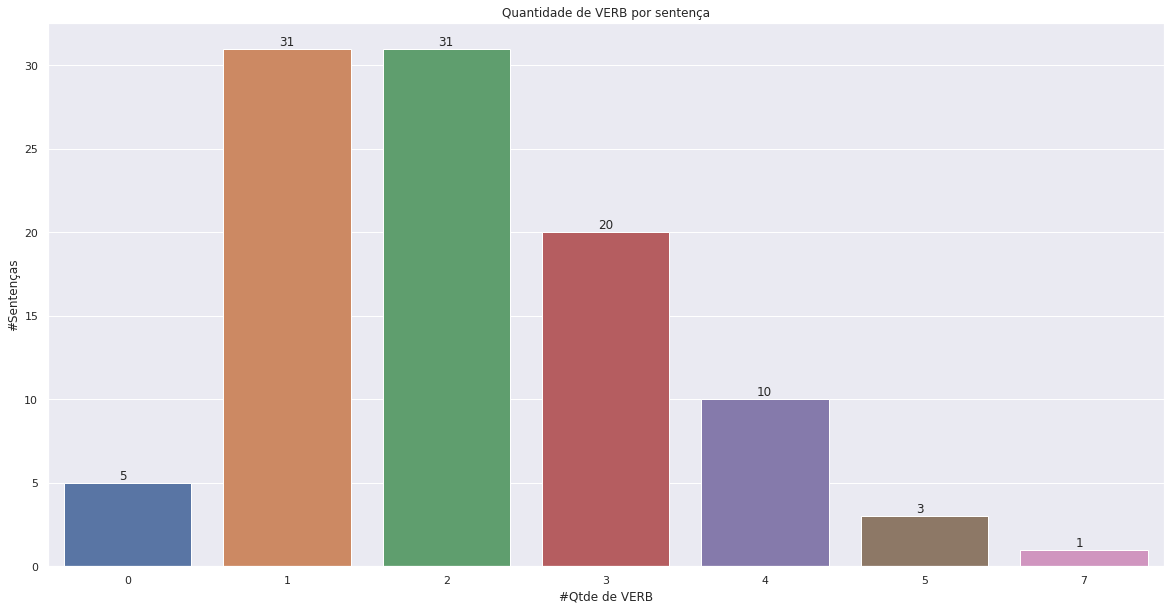

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

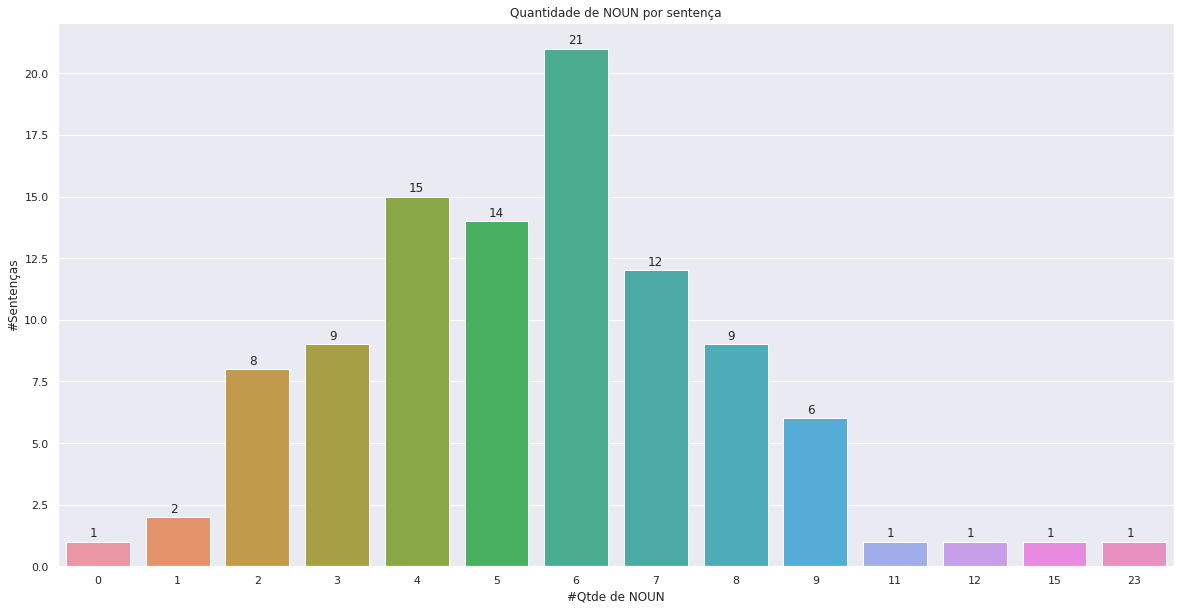

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

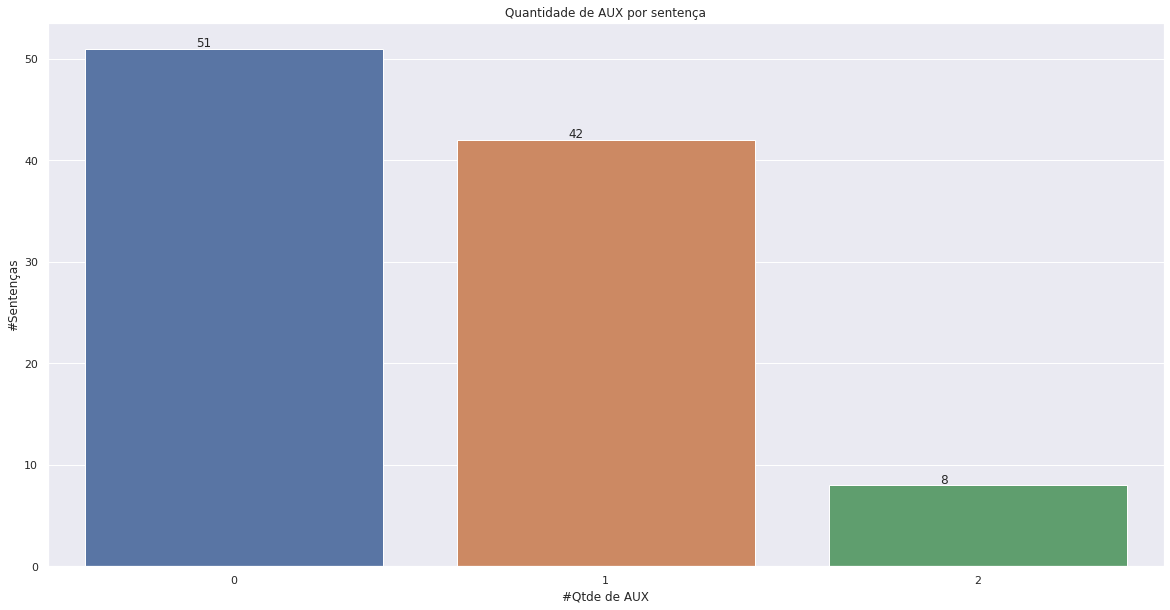

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

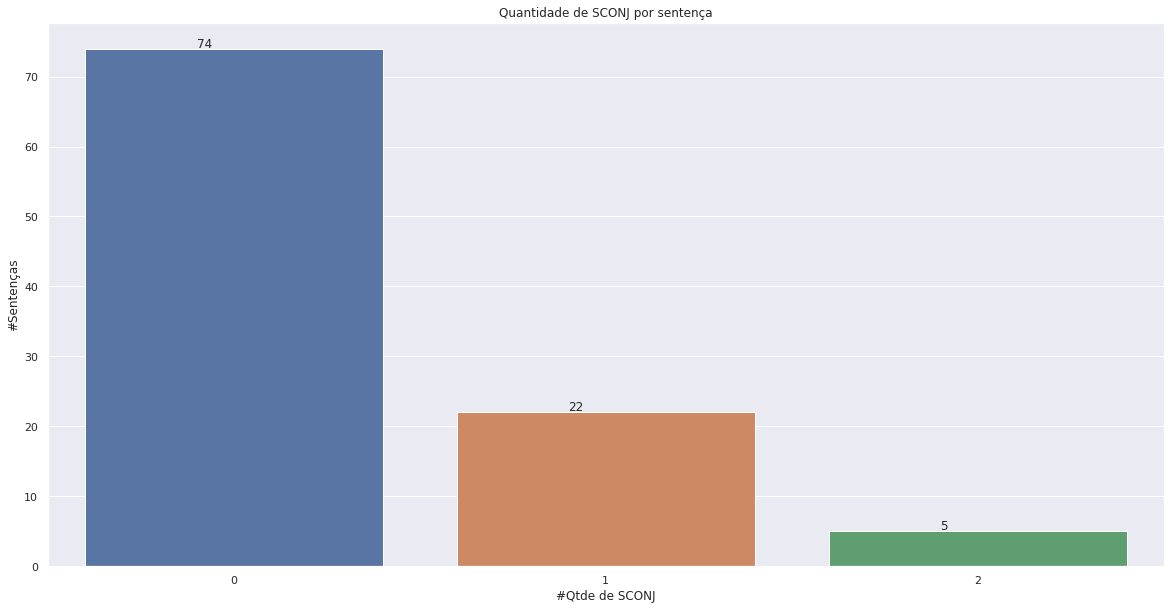

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

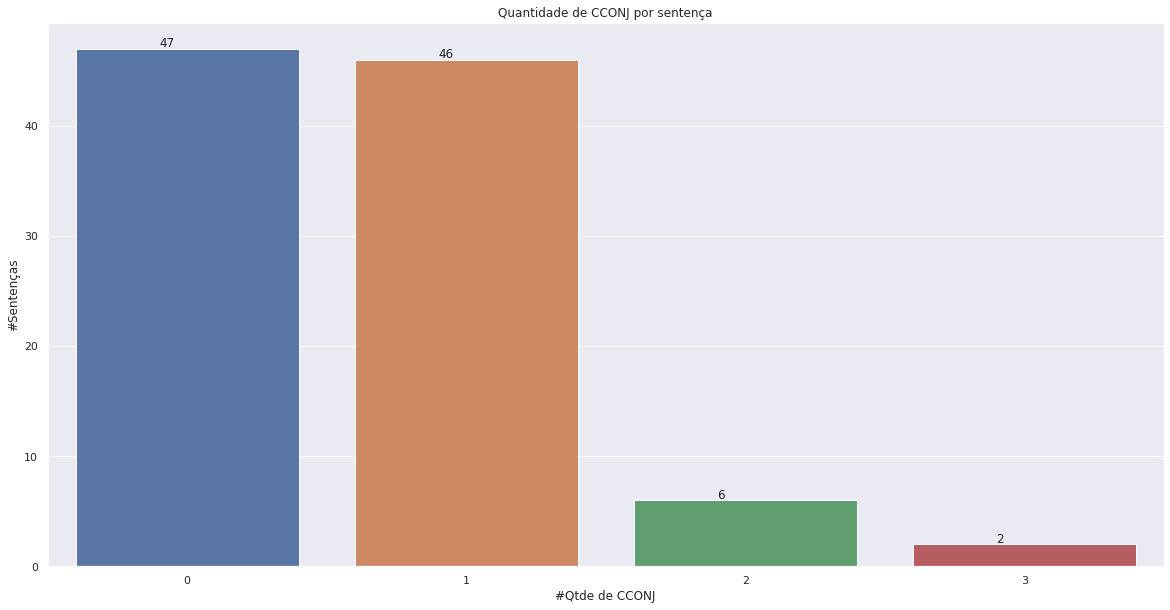

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

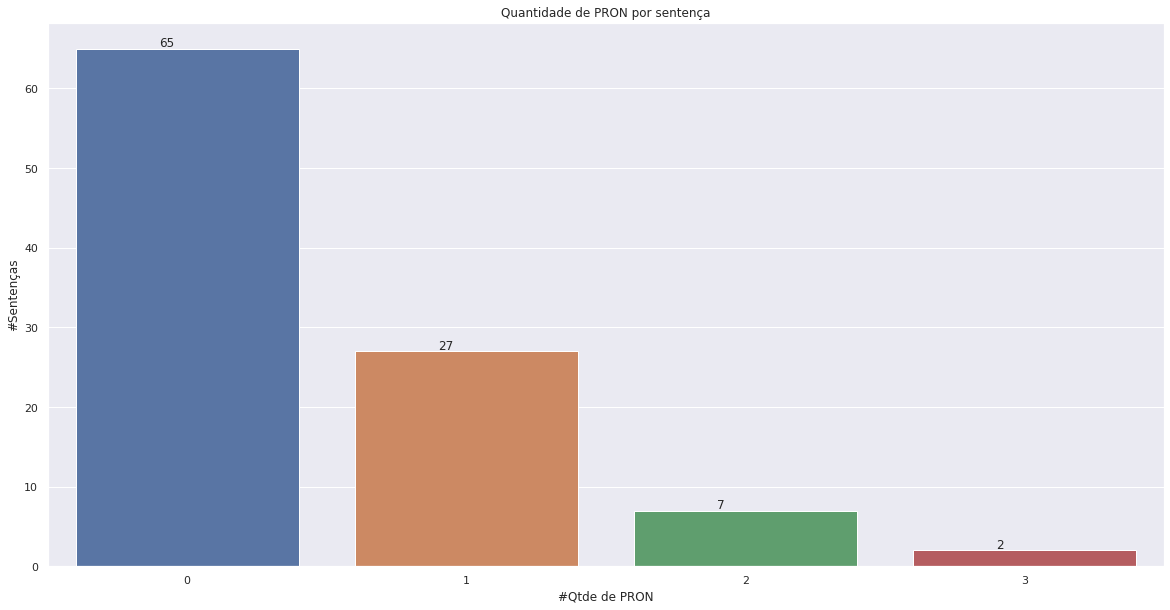

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

### 5.2.5 Por Documento

#### 5.2.5.1 Gráfico Quantidade de documentos por quantidade de sentenças

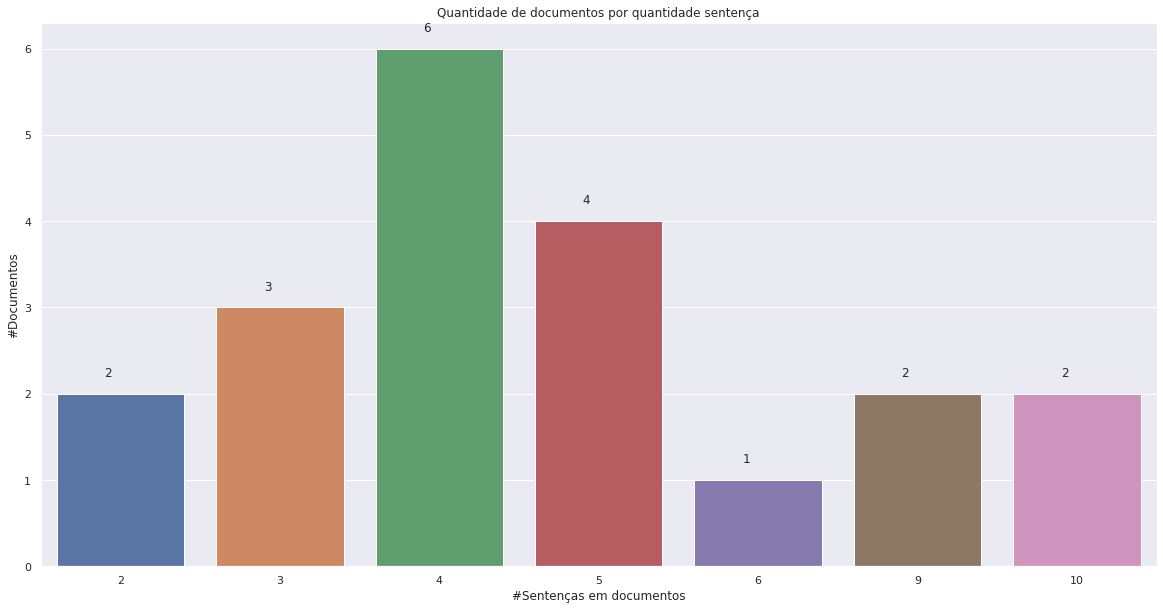

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de documentos por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.2 Gráfico Quantidade de documentos  por quantidade de palavras

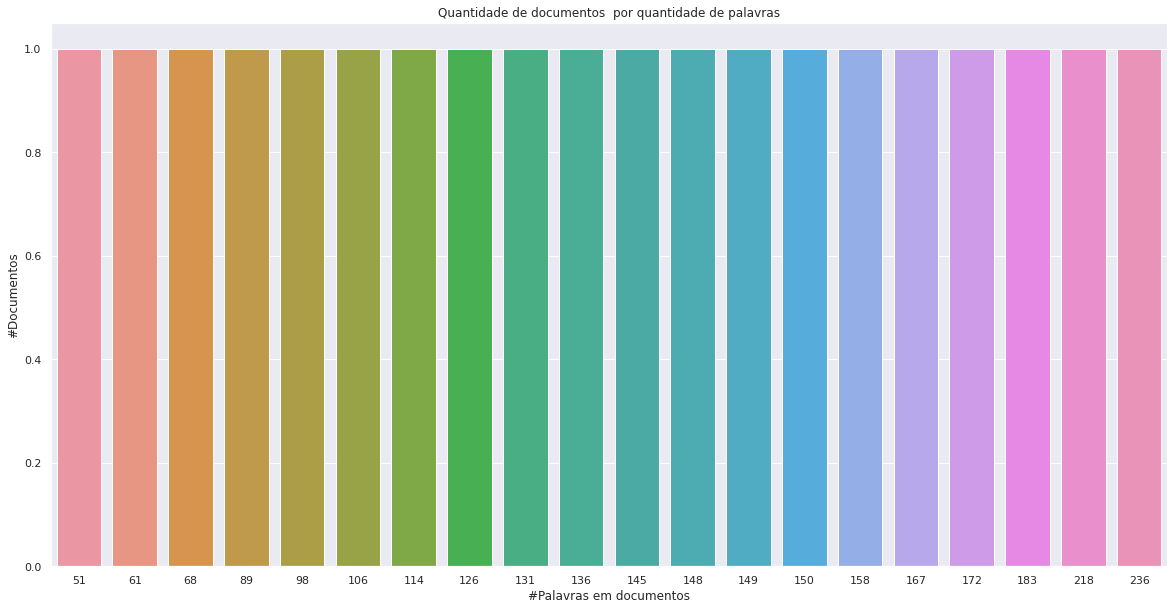

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos  por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.3 Gráfico Quantidade de documentos  por quantidade de tokens

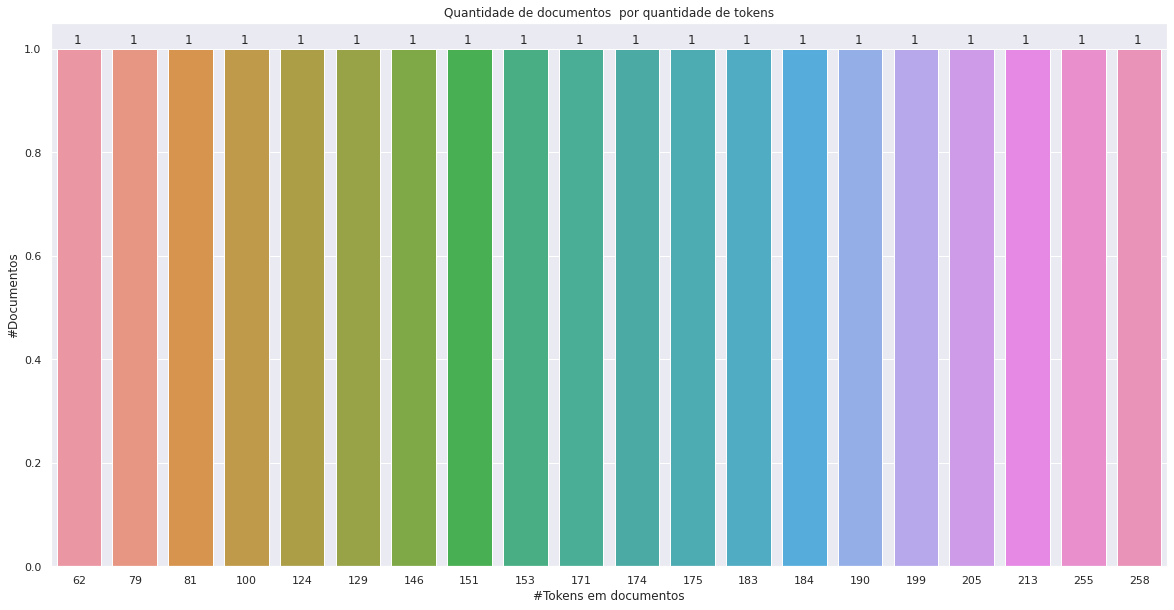

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de tokens")
plt.xlabel("#Tokens em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.4 Gráfico Quantidade de documentos  por quantidade de palavras desconsiderando as stopword

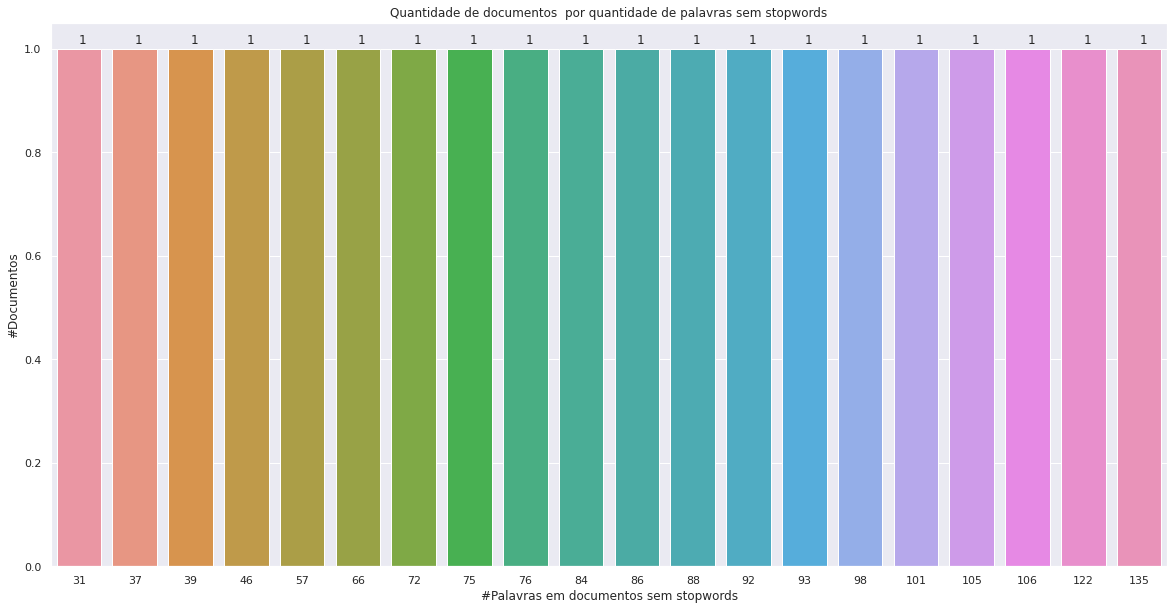

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.5 Gráfico Quantidade de documentos  por quantidade de locuções verbais

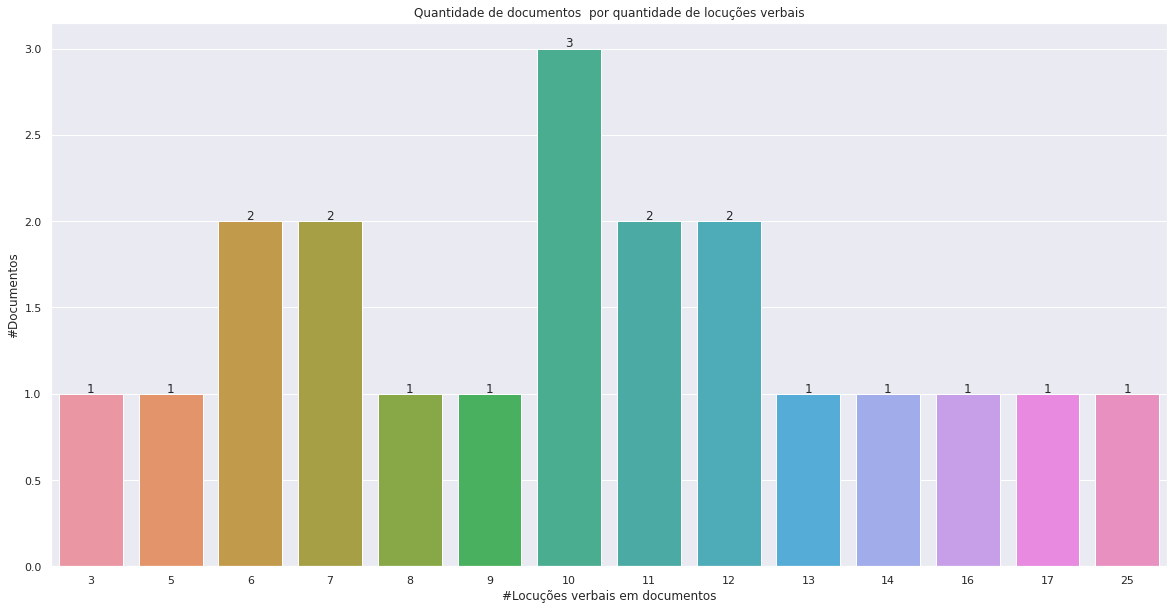

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.6 Gráfico Quantidade de documentos  por quantidade de verbos

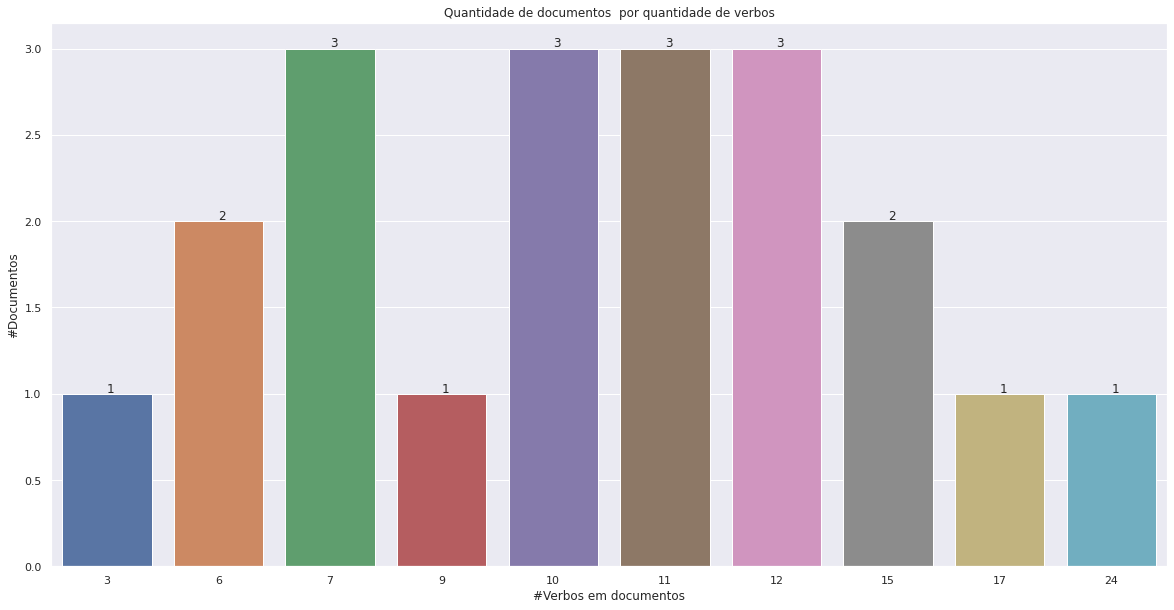

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.7 Gráfico Quantidade de documentos  por quantidade de verbos e aux

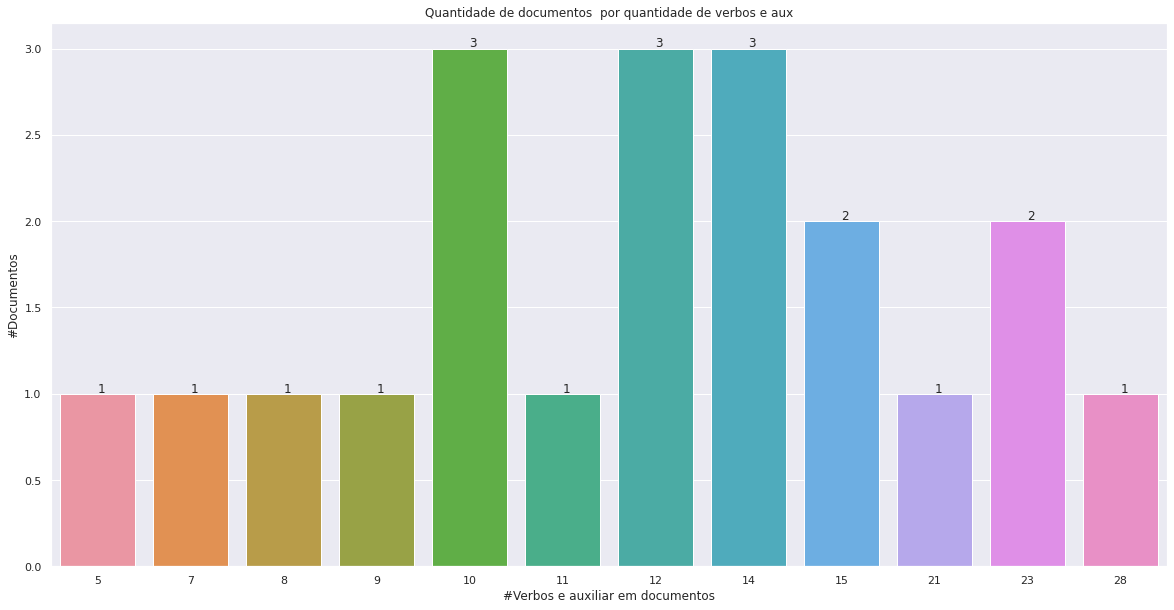

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.8 Gráfico Quantidade de documentos  por quantidade de substantivos

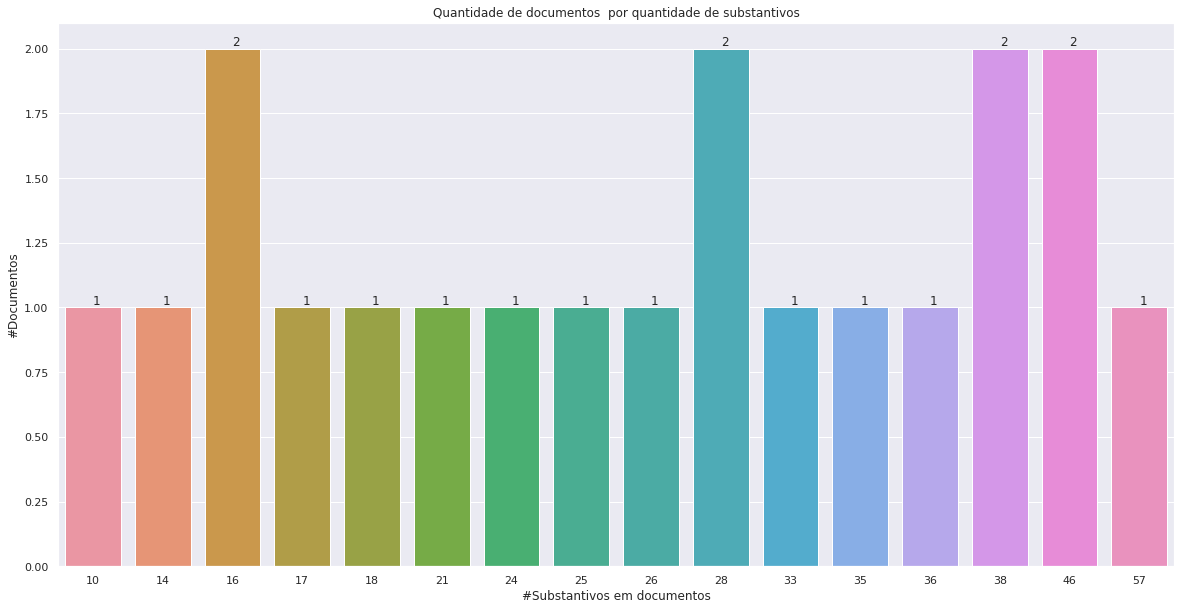

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.9 Gráfico Quantidade de documentos  por quantidade de verbos(AUX) e substantivo

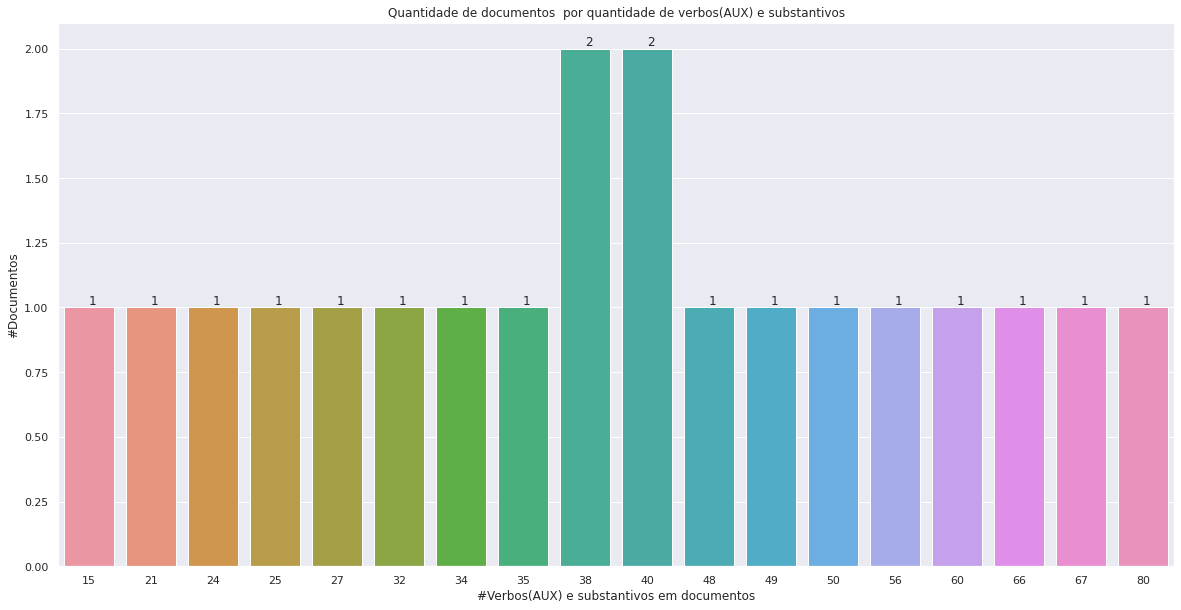

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbosauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.10 Gráfico da distribuição do comprimento dos documentos tokenizados

In [ ]:
# Recupera o comprimento dos documentos tokenizados
tamanhos_sentencas = [len(x) for x in documento_tokenizado]

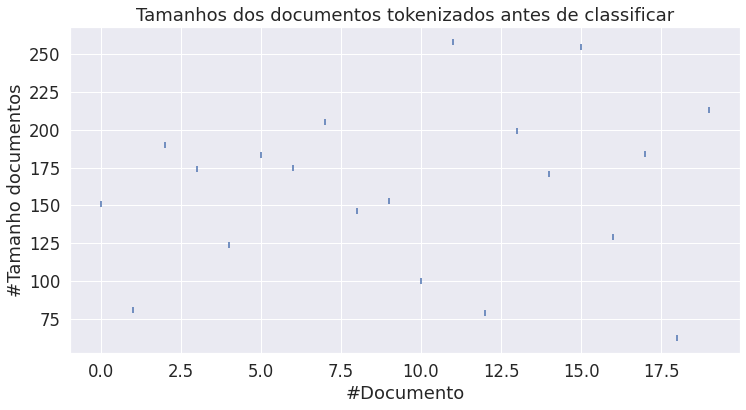

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Adiciona os valores as colunas
plt.scatter(range(0, len(tamanhos_sentencas)), tamanhos_sentencas, marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados antes de classificar")

plt.show()

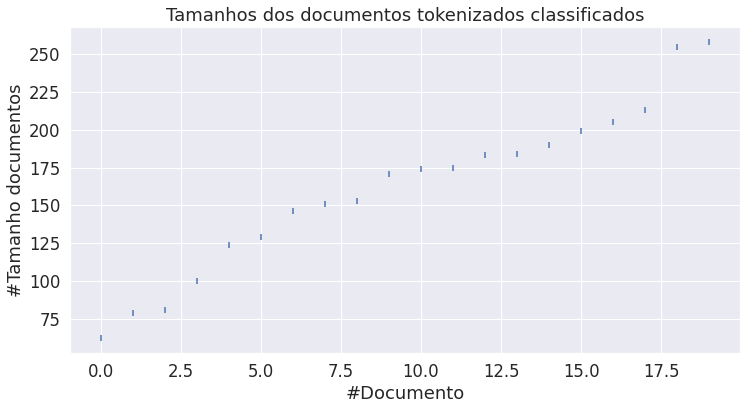

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(tamanhos_sentencas)), sorted(tamanhos_sentencas), marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados classificados")

plt.show()

### 5.2.6 Por sentença

#### 5.2.6.1 Gráfico Quantidade de sentenças de documentos  por quantidade de palavras

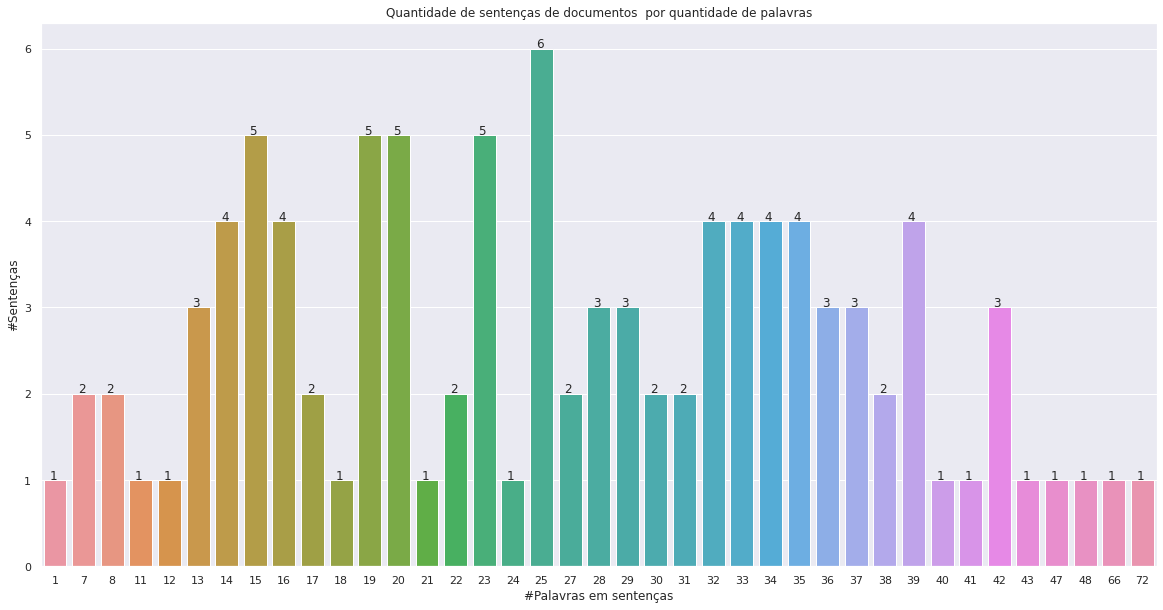

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos  por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.2 Gráfico Quantidade de sentenças de documentos  por quantidade de tokens

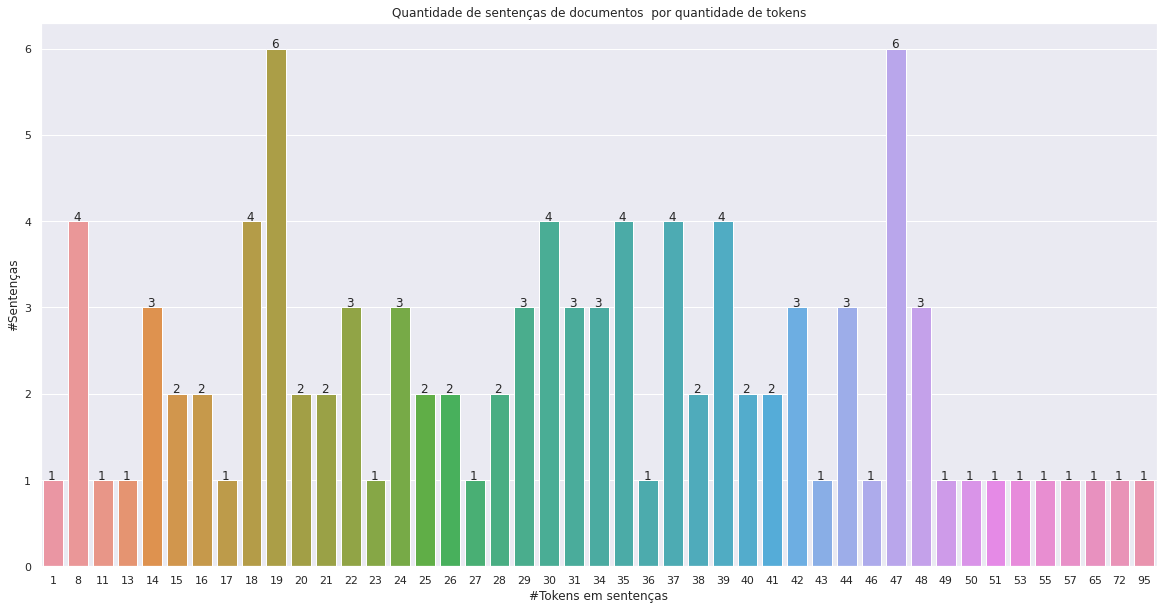

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos  por quantidade de tokens")
plt.xlabel("#Tokens em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.3 Gráfico Quantidade de sentenças de documentos  por quantidade de palavras desconsiderando stopwords

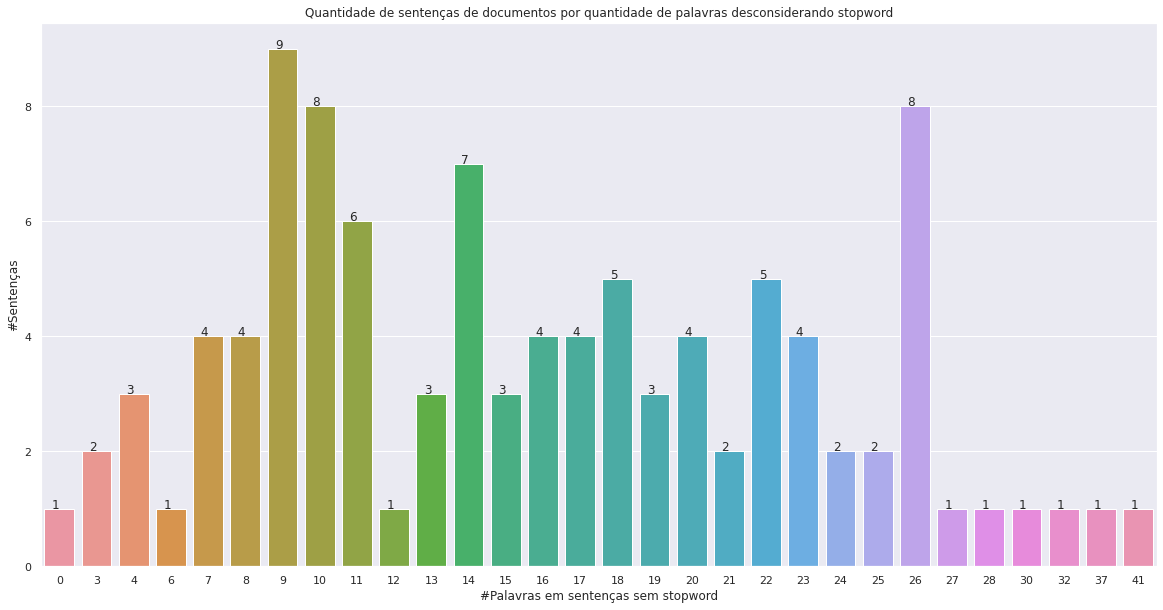

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.4 Gráfico Quantidade de sentenças de documentos  por quantidade de locuções verbais

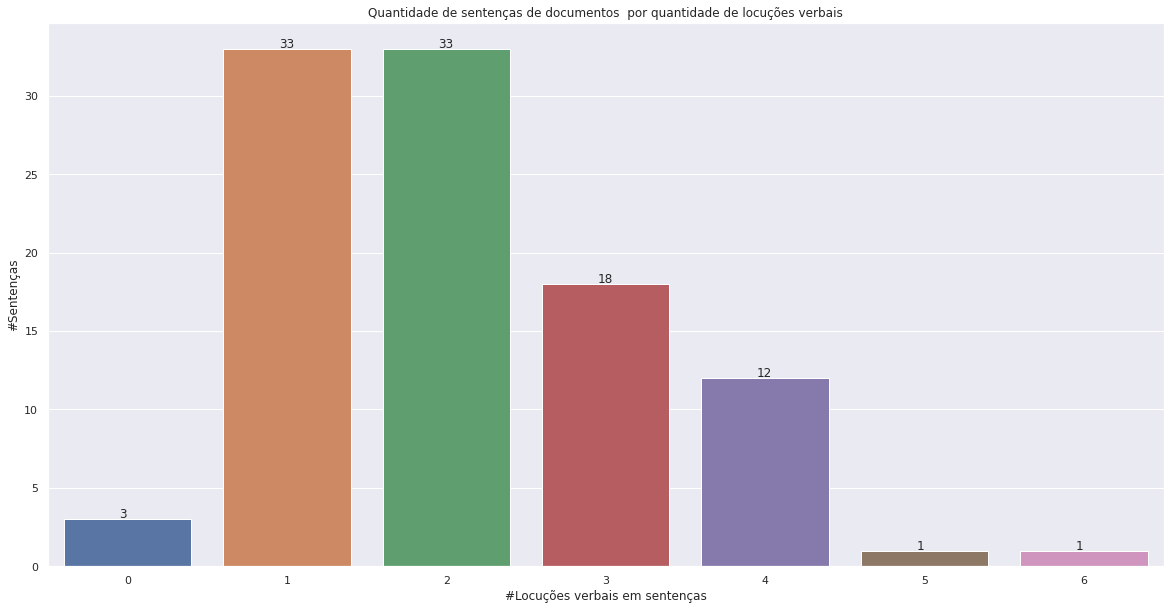

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.5 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos

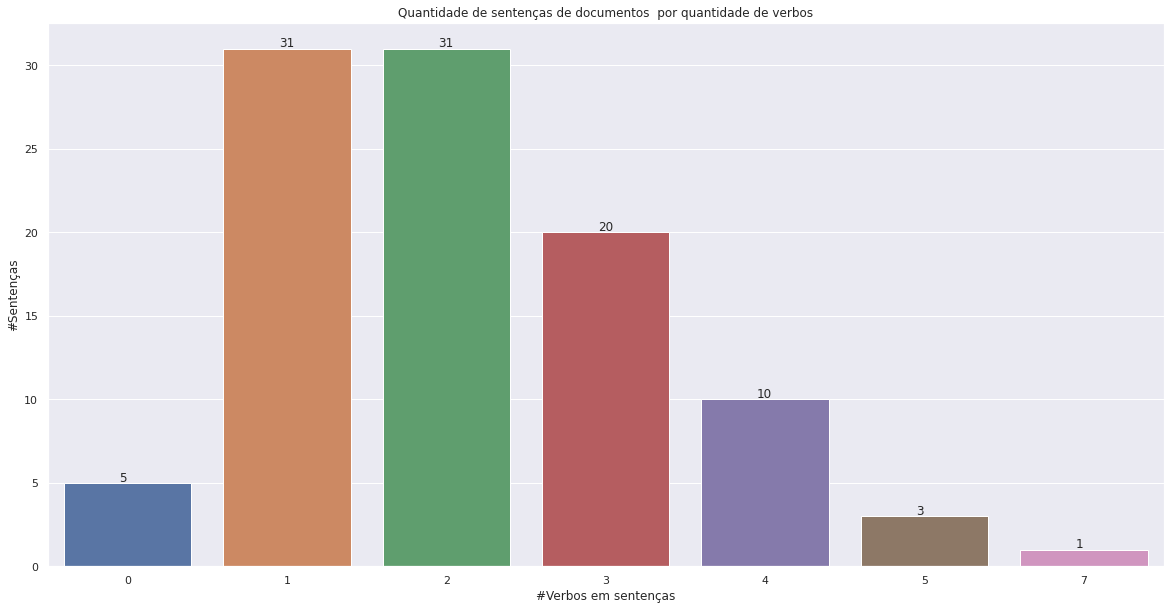

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.6 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos e aux

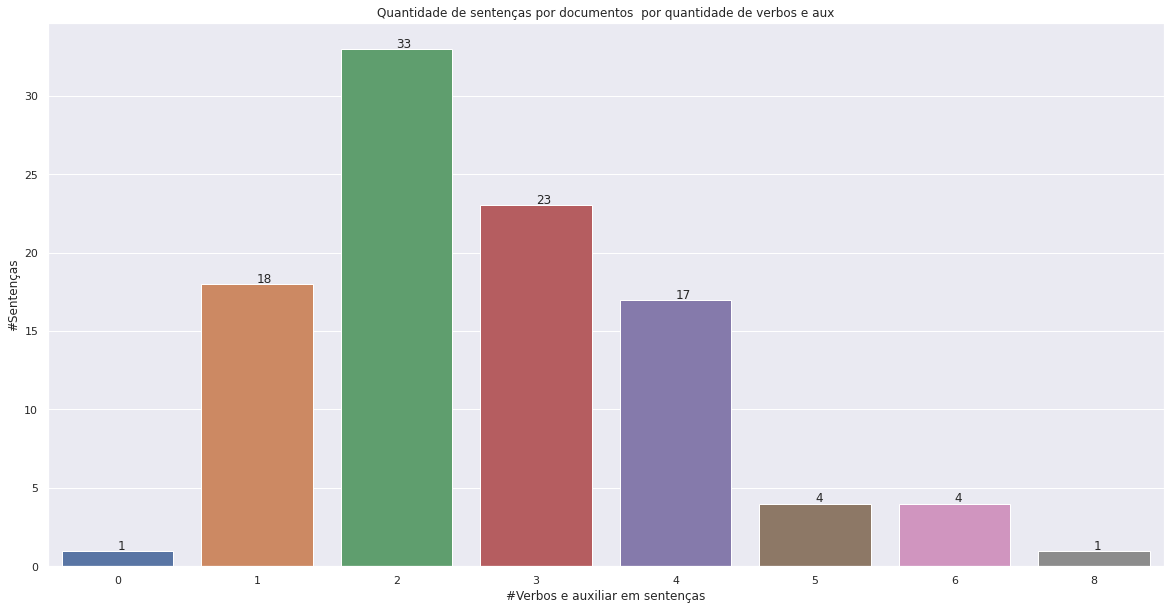

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos  por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.7 Gráfico Quantidade de sentenças de documentos  por quantidade de substantivos

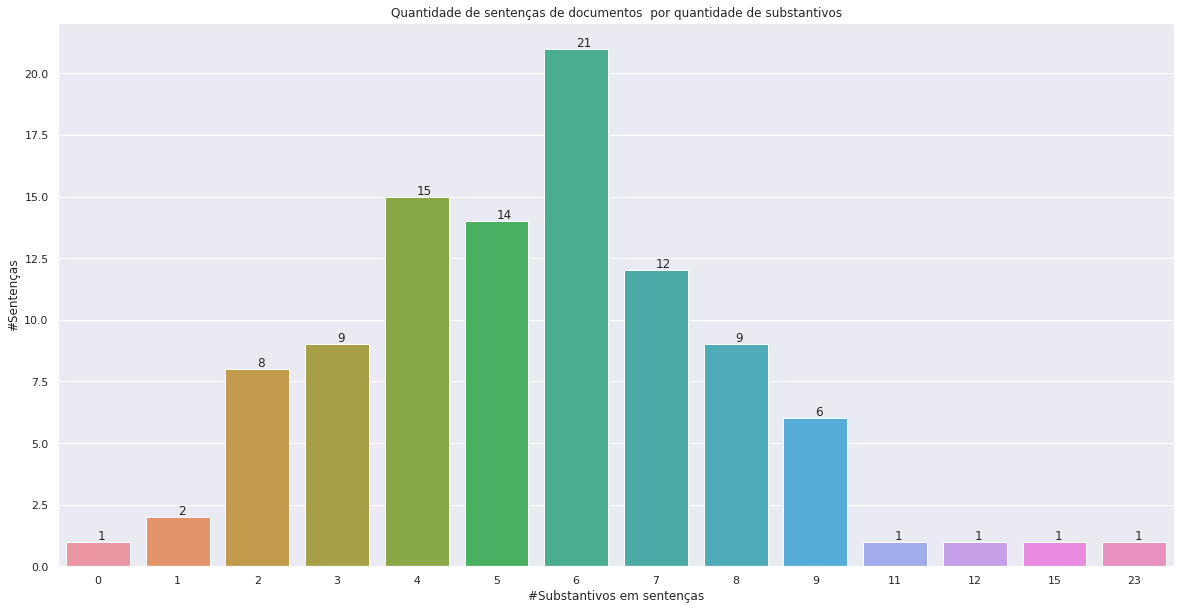

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.8 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(AUX) e substantivo

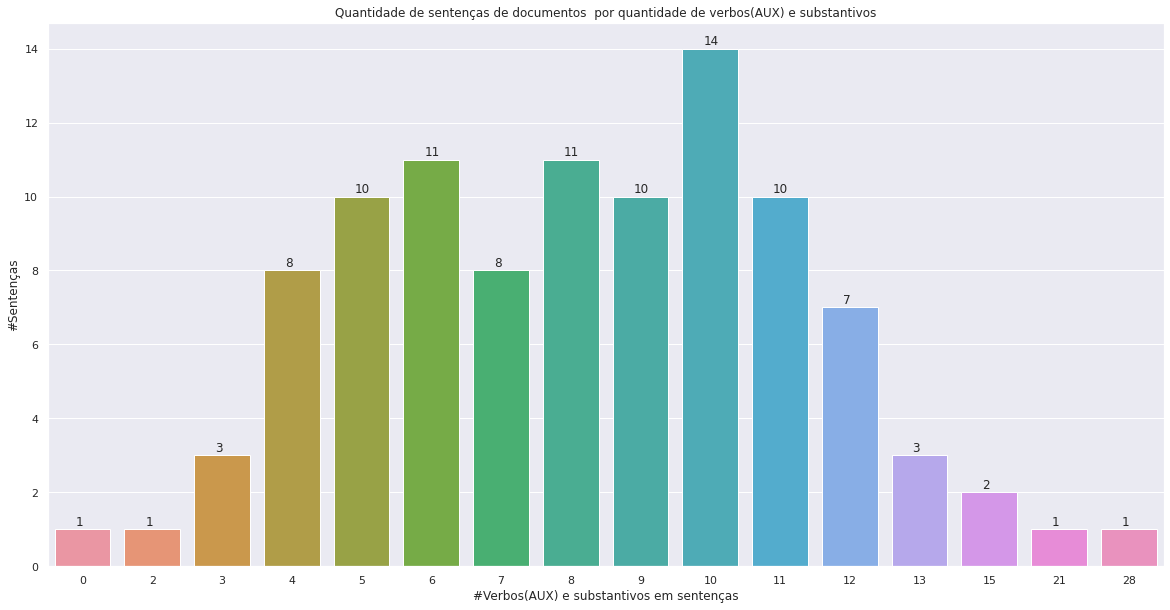

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

# 6 Finalização

## 6.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:04:20 (h:mm:ss)
